## Random Shape Dataset Generation
The purpose of this notebook is to generate a dataset/configuration useful for testing cytometry methods against a known ground-truth.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import draw
from skimage import util
from skimage import morphology
from skimage import measure
from skimage import segmentation
from cytokit.cytometry import cytometer
from cytokit import tiling
%matplotlib inline

### Generate Data

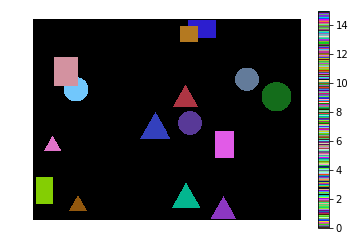

In [2]:
# Create 3x3 tile images with random shapes
# Ideally there should be some tiles with no shapes,
# shapes split across boundaries, and shapes occluding one another
shape = (135, 180)
nr, nc = 3, 3
seed = 1

# Build colormap for displaying discrete values
np.random.seed(seed)
randc = np.random.rand(256,3)
randc[0] = np.array([0, 0, 0])
cmap = mpl.colors.ListedColormap(randc)

# Generate shapes noting that the number of shapes in result may
# not equal number in parameters as they can completely occlude one another
im, lbls = draw.random_shapes(
    (shape[0]*nr, shape[1]*nc), min_shapes=15, max_shapes=15, 
    min_size=32, max_size=64, allow_overlap=True, multichannel=False,
    random_seed=seed)

# Set background to 0 and assign a sequential id to each object
im[im == 255] = 0
im = segmentation.relabel_sequential(im)[0]
assert im.max() <= 255
im = im.astype(np.uint8)
plt.imshow(im, cmap=cmap)
plt.axis('off')
plt.colorbar()

In [3]:
ids = np.unique(im[im > 0])
# Ensure that ids only capture non-background objects
assert np.array_equal(np.isin(im, ids), im > 0)

### Visualize

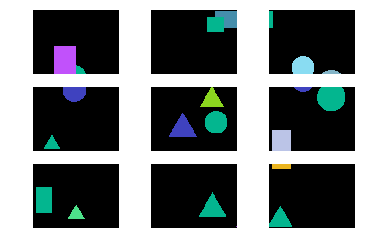

In [4]:
imgrid = util.view_as_blocks(im, shape)
imgrln = imgrid.reshape((-1,)+shape)
grid_shape = imgrid.shape[:2]

def plot_grid(im, fn=None):
    fig, ax = plt.subplots(*grid_shape)
    for r, c in np.ndindex(grid_shape):
        imv = im[r, c]
        if fn is not None:
            imv = fn(imv)
        ax[r, c].imshow(imv, cmap=cmap)
        ax[r, c].axis('off')
        ax[r, c].grid(False)
plot_grid(imgrid)

In [5]:
imgrln.shape

(9, 135, 180)

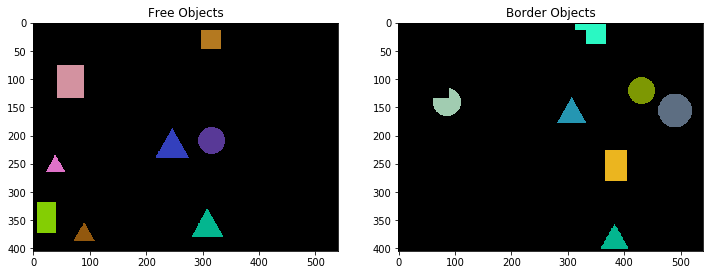

In [6]:
# Identify objects on border
imgc = util.montage(np.stack([segmentation.clear_border(im) for im in imgrln]))
assert imgc.shape == im.shape
ids_free = np.unique(imgc)
ids_brdr = np.setdiff1d(ids, ids_free)

# Visualize original image for free and for boundary objects
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
ax[0].set_title('Free Objects')
ax[0].imshow(im * np.isin(im, ids_free), cmap=cmap)
ax[1].set_title('Border Objects')
ax[1].imshow(im * np.isin(im, ids_brdr), cmap=cmap)

### Generate Configuration

In [7]:
import cytokit
import os.path as osp
from cytokit import config as ck_config
from cytokit import io as ck_io
nchannels = 3
path_format = "T{tile:02d}_C{channel:02d}.tif"
exp_dir = osp.join(cytokit.test_data_dir, 'experiment', 'random-shapes')

In [8]:
# Pull the template configuration and add properties relevant to this experiment
config = ck_config.load_example_config('template')
config._conf['environment'] = {'path_formats': 'get_default_path_formats("' + path_format + '")'}
config._conf['processor'] = {'tile_generator': {'raw_file_type': 'grayscale'}}
config._conf['name'] = 'Random Shapes'
config._conf['date'] = str(pd.to_datetime('now'))
acq = config._conf['acquisition']
acq['per_cycle_channel_names'] = ['CH{}'.format(i) for i in range(1, nchannels + 1)]
acq['channel_names'] = ['C{}'.format(i) for i in range(1, nchannels + 1)]
acq['emission_wavelengths'] = [0]*nchannels
acq['region_height'], acq['region_width'] = grid_shape
acq['tile_height'], acq['tile_width'] = shape
config._conf

{'acquisition': {'axial_resolution': 1,
  'channel_names': ['C1', 'C2', 'C3'],
  'emission_wavelengths': [0, 0, 0],
  'lateral_resolution': 1,
  'magnification': 1,
  'num_cycles': 1,
  'num_z_planes': 1,
  'numerical_aperture': 1,
  'objective_type': 'air',
  'per_cycle_channel_names': ['CH1', 'CH2', 'CH3'],
  'region_height': 3,
  'region_names': ['Region1'],
  'region_width': 3,
  'tile_height': 135,
  'tile_overlap_x': 0,
  'tile_overlap_y': 0,
  'tile_width': 180,
  'tiling_mode': 'grid'},
 'date': '2019-03-08 15:46:18',
 'environment': {'path_formats': 'get_default_path_formats("T{tile:02d}_C{channel:02d}.tif")'},
 'name': 'Random Shapes',
 'processor': {'tile_generator': {'raw_file_type': 'grayscale'}}}

In [9]:
config_path = osp.join(exp_dir, 'config', 'experiment.yaml')
ck_config.save(config_path, config)
config_path

'/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/config/experiment.yaml'

### Export Images

In [10]:
# Raw tile export

def create_tile(im):
    # Create tile to quantify as (cyc, z, ch, h, w) w/ channels as multiples of original image
    tile = np.stack([im * i for i in range(1, nchannels + 1)])
    assert tile.shape[0] == nchannels
    # Ensure that the first channel is equal to original, as this channel will be used as object reference
    assert np.array_equal(tile[0], im)
    # Add tile and z dimensions
    tile = tile[np.newaxis, np.newaxis]
    assert tile.ndim == 5
    return tile

tiler = tiling.GridTiling()
for r, c in np.ndindex(grid_shape):
    tile = create_tile(imgrid[r, c])
    idx = tiler.index_from_coordinates(c, r, *grid_shape)
    for ich in range(nchannels):
        path = osp.join(exp_dir, 'raw', path_format.format(tile=idx+1, channel=ich+1))
        image = tile[0, 0, ich]
        assert image.ndim == 2
        ck_io.save_image(path, image)
        print(path)

/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T01_C01.tif
/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T01_C02.tif
/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T01_C03.tif
/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T02_C01.tif
/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T02_C02.tif
/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T02_C03.tif
/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T03_C01.tif
/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T03_C02.tif
/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T03_C03.tif
/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T04_C01.tif
/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/raw/T04_C02.tif
/lab/repos/cytokit/python/pipeline/tests/da

In [11]:
# Validation image export
path = osp.join(exp_dir, 'validation', 'original_shapes_image.tif')
ck_io.save_image(path, im)
path

'/lab/repos/cytokit/python/pipeline/tests/data/experiment/random-shapes/validation/original_shapes_image.tif'

### Test Development

**NOTE**: This should not refer to any variables above and should instead assume everything comes off disk

In [12]:
config = ck_config.load(config_path)
config.register_environment()
from cytokit.ops import tile_generator
from cytokit.function import core as ck_core

In [13]:
region_shape = config.region_height, config.region_width
region_shape

(3, 3)

In [14]:
tiles = [
    tile_generator.CytokitTileGenerator(config, osp.join(exp_dir, 'raw'), region_index=0, tile_index=i).run()
    for i in range(config.n_tiles_per_region)
]
tiles[0].shape

(1, 1, 3, 135, 180)

In [15]:
img_mtv = ck_io.read_image(osp.join(exp_dir, 'validation', 'original_shapes_image.tif'))
img_mtv.shape, img_mtv.dtype

((405, 540), dtype('uint8'))

In [16]:
# Create montage from first channel (which contains object ids for reference)
img_mtg = ck_core.montage(tiles, config)[0, 0, 0]
img_mtg.shape, img_mtg.dtype

((405, 540), dtype('uint8'))

In [17]:
assert np.array_equal(img_mtv, img_mtg)

In [29]:
# Classify objects as either free or on border
img_clr = util.montage(np.stack([segmentation.clear_border(t[0, 0, 0]) for t in tiles]))
assert img_clr.shape == img_mtg.shape
ids = np.unique(img_mtg[img_mtg > 0])
ids_free = np.setdiff1d(np.unique(img_clr), [0])
ids_brdr = np.setdiff1d(ids, ids_free)
assert np.all(ids_free > 0) and np.all(ids_brdr > 0) and np.all(ids > 0)

In [19]:
def create_segments(im):
    # Create segmentation images as (z, ch, h, w)
    imb = segmentation.find_boundaries(im, mode='inner')
    segments = np.stack([im, im, imb, imb])[np.newaxis]
    assert segments.ndim == 4
    return segments

df = pd.concat([
    cytometer.CytometerBase.quantify(
        tiles[i], create_segments(tiles[i][0, 0, 0]),
        channel_names=config.channel_names, 
        cell_intensity=['mean', 'median', 'sum', 'var'], nucleus_intensity=False, 
        cell_graph=True, border_features=True, morphology_features=True
    )
    .assign(tile_x=c, tile_y=r, tile_index=i)
    for i, (r, c) in enumerate(np.ndindex(region_shape))
])

In [20]:
#df.info()

In [82]:
assert len(np.intersect1d(ids, df['id'].unique())) == len(ids), \
    'Object ids expected do not match those found\nIds found: {}\nIds expected: {}'\
    .format(sorted(df['id'].unique()), sorted(ids))

# Check that objects classified as on border or not are correct
assert np.array_equal(sorted(df[df['cb:on_border'] > 0]['id'].unique()), sorted(ids_brdr))
assert np.array_equal(sorted(df[df['cb:on_border'] < 1]['id'].unique()), sorted(ids_free))

for i, r in df.iterrows():
    # Fetch tile image from tile list and make sure that size of cell returned
    # matches that in image
    area = (tiles[r['tile_index']][0, 0, 0] == r['id']).sum()
    assert r['cm:size'] == area
    
    # For each channel validate that:
    # - mean and median equal the id times channel index (1-based)
    # - sum equals area times id times channel index
    # - variance is 0
    for j, c in enumerate(config.channel_names):
        for f in ['mean', 'median']:
            assert r['id'] * (j+1) == r['ci:{}:{}'.format(c, f)]
        assert r['id'] * (j+1) * area == r['ci:{}:sum'.format(c)]
        assert 0 == r['ci:{}:var'.format(c)]
    
    